In [37]:
# https://www.datacamp.com/community/tutorials/recommender-systems-python
# I would like to Datacamp for this tutorial 
# Import Pandas
import pandas as pd
# https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv

# Load Movies Metadata
metadata = pd.read_csv('movies_metadata.csv', low_memory=False)

# Print the first three rows
metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


# Data Visualization 

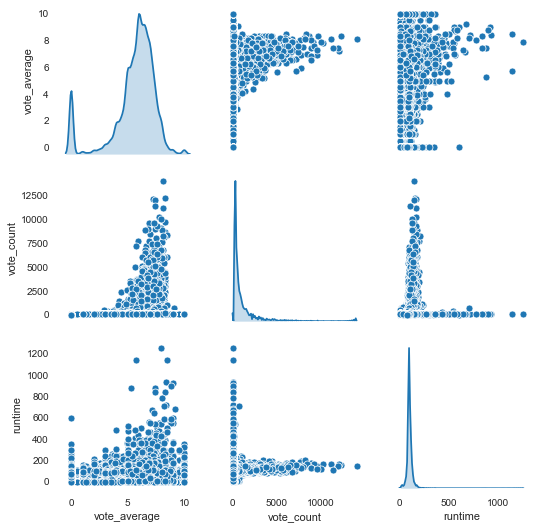

In [67]:
import seaborn as sns
sns.pairplot(metadata[['vote_average', 'vote_count', "runtime", "budget"]], diag_kind="kde",)

In [38]:
from pandas_profiling import ProfileReport
train_profile = ProfileReport(metadata, title='Pandas Profiling Report', html={'style':{'full_width':True}})
train_profile

In [41]:
# shape of the dataset 
metadata.shape

(45466, 24)

In [6]:
C = metadata['vote_average'].mean()
print(C)

5.618207215133889


In [7]:
m = metadata['vote_count'].quantile(0.90)
print(m)

160.0


In [46]:
# Filter out all qualified movies into a new DataFrame according to the vote count mean 
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

In [47]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [48]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)
q_movies['score']

0        7.640253
1        6.820293
4        5.660700
5        7.537201
8        5.556626
           ...   
45177    4.959104
45204    6.671272
45258    6.590372
45265    6.344369
45343    4.791783
Name: score, Length: 4555, dtype: float64

In [49]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head()

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385


In [53]:
len(q_movies)

4555

In [50]:
#Print plot overviews of the first 5 movies.
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [54]:
len(metadata)

45466

##### In its current form, it is not possible to compute the similarity between any two overviews. To do this, you need to compute the word vectors of each overview or document, as it will be called from now on.
##### You will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each document. This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each column represents a movie, as before.
##### In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.
##### Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines.

In [51]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata['overview'] = metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(45466, 75827)

##### You see that over 75,000 different words were used to describe the 45,000 movies in your dataset.
##### With this matrix in hand, you can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. Again, there is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.
##### You will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. You use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate (especially when used in conjunction with TF-IDF scores, which will be explained later). Mathematically, it is defined as follows: 
##### cosine(x,y)=x.yT/(|x||.||y||)
##### Since you have used the TF-IDF vectorizer, calculating the dot product will directly give you the cosine similarity score. Therefore, you will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster

In [17]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

- You're going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, you need a reverse mapping of movie titles and DataFrame indices. In other words, you need a mechanism to identify the index of a movie in your metadata DataFrame, given its title.

In [18]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

- You are now in a good position to define your recommendation function. These are the following steps you'll follow:
- Get the index of the movie given its title.
- Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
- Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
- Return the titles corresponding to the indices of the top elements.

In [33]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return pd.DataFrame(metadata['title'].iloc[movie_indices].values, columns = ['Similar Movies'])

In [34]:
get_recommendations('The Dark Knight Rises')

,Similar Movies
0,The Dark Knight
1,Batman Forever
2,Batman Returns
3,Batman: Under the Red Hood
4,Batman
5,Batman Unmasked: The Psychology of the Dark Kn...
6,Batman Beyond: Return of the Joker
7,Batman: Year One
8,"Batman: The Dark Knight Returns, Part 1"
9,Batman: Mask of the Phantasm


In [35]:
get_recommendations('The Godfather')

,Similar Movies
0,The Godfather: Part II
1,The Godfather Trilogy: 1972-1990
2,The Godfather: Part III
3,Blood Ties
4,Household Saints
5,Start Liquidation
6,Election
7,A Mother Should Be Loved
8,Short Sharp Shock
9,Beck 28 - Familjen
